## What is this?

This Jupyter Notebook contains Python code for building a LSTM Recurrent Neural Network that gives 87-88% accuracy on the IMDB Movie Review Sentiment Analysis Dataset. 

More information is given on [this blogpost](https://www.bouvet.no/bouvet-deler/explaining-recurrent-neural-networks).

This code is partly based on [markwest1972's](https://github.com/markwest1972/LSTM-Example-Google-Colaboratory) Notebook on LSTM-Example-Google-Colaboratory

## Built for Google Collaboratory

Train your network more quickly in Google Collaboratory. From the **Runtime** menu select **Change Runtime** Type and choose "GPU"!

Don't forget to select **Runtime** -> **Restart runtime** to put your changes into effect.

## Setting up

When running this for the first time you may get a warning telling you to restart the Runtime. You can ignore this, but feel free to select "Runtime->Restart Runtime" from the overhead menu if you encounter problems.

In [1]:
# Imports
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Fetch "IMDB Movie Review" data from tensorflow (https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb)
# and constrain the reviews to 10000 most commonly used words.
# Note here the vocab_size is equal to 10000 common words.
### START CODE HERE ###
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
### END CODE HERE ###

# Map for readable classnames
class_names = ["Negative", "Positive"]

17465344/17464789 [==============================] - 0s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mus

## Create map for converting IMDB dataset to readable reviews

Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also 
contains an index for converting the reviews back into human readable form.
This is the process of creating a dictionary.

In [2]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


## Data Insight

Here we take a closer look at our data. How many words do our reviews contain?

And what do our review look like in machine and human readable form?


In [6]:
# Concatenate x_train and x_test datasets and return it as allreviews.
### START CODE HERE ###
allreviews = np.concatenate((x_train, x_test))
### END CODE HERE ###

print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))

# Use allreviews to calculate the lengths across the training and test dataset and return as result.
### START CODE HERE ###
result = np.concatenate((y_train, y_test))
### END CODE HERE ###
print("Mean review length: {}".format(np.mean(result)))


# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 0.5

Machine readable Review
  Review Text: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Review Sentiment: 0

Human Readable Review
  Review Text: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> but yo

## Pre-processing Data

We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

Some reviews will need to be truncated, while others need to be [padded](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
Further reading on [Padding for NLP](https://medium.com/@canerkilinc/padding-for-nlp-7dd8598c916a).

In [7]:
# The length of reviews
review_length = 500

# Padding / truncated our reviews
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
# Perform the same for x_test
### START CODE HERE ###
x_test = sequence.pad_sequences(x_test, maxlen=review_length)
### END CODE HERE ###

# Check the size of our datasets. Review data for both test and training should 
# contain 25000 reviews of 500 integers. Class data should contain 25000 values, 
# one for each review. Class values are 0 or 1, indicating a negative 
# or positive review.
print("Shape Training Review Data: " + str(x_train.shape))
print("Shape Training Class Data: " + str(y_train.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train[60]))

Shape Training Review Data: (25000, 500)
Shape Training Class Data: (25000,)
Shape Test Review Data: (25000, 500)
Shape Test Class Data: (25000,)

Human Readable Review Text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

## Create and build LSTM Recurrent Neural Network

You will be using a Sequential Model to build the LSTM. A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. The other way to build a model is by using the Functional API. Take a look at [Sequential API vs Functional API model in Keras](https://medium.com/@hanify/sequential-api-vs-functional-api-model-in-keras-266823d7cd5e) to read about the differences between the two and how to create a Sequential and a Functional API.

References: 
- [Keras Sequential API](https://keras.io/guides/sequential_model/)
- [Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
- [Dropout Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
- [CuDNNLSTM](https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNLSTM)
- [Dense Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
- [Binary Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- [Adam Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

In [13]:
# We begin by defining a empty stack called model using tf.keras.Sequential.
# We'll use this for building our network, layer by layer.
### START CODE HERE ###
model = tf.keras.Sequential()
### END CODE HERE ###

# The Embedding Layer provides a spatial mapping (or Word Embedding) of all the 
# individual words in our training set. Words close to one another share context 
# and or meaning. This spatial mapping is learned during the training process.

# To create a Embedding Layer, use the following parameters:
#   - input_dim as your vocab_size
#   - output_dim as 32 to which each words shall be mapped
#   - the input_length will be review_length, the length of input sequences
### START CODE HERE ###
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=32, input_length=review_length))
### END CODE HERE ###

# Dropout layers fight overfitting and forces the model to learn multiple 
# representations of the same data by randomly disabling neurons in the 
# learning phase.

# To create a Dropout layer, use the rate as 0.25. This will disable 25% of neurons
### START CODE HERE ###
model.add(tf.keras.layers.Dropout(0.25))
### END CODE HERE ###

# We are using a fast version of LSTM whih is optimised for GPUs. This layer 
# looks at the sequence of words in the review, along with their word embeddings
# and uses both of these to determine to sentiment of a given review.

# To create the fast LSTM, use CuDNNLSTM with 32 units.
# This will be the LSTM units in this layer.
### START CODE HERE ###
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(32,kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
))
### END CODE HERE ###

# Add a second dropout layer with the same aim as the first with a 25% dropout rate.
### START CODE HERE ###
model.add(tf.keras.layers.Dropout(0.25))
### END CODE HERE ###

# All LSTM units are connected to a single node in the dense layer. A sigmoid 
# activation function determines the output from this node - a value 
# between 0 and 1. Closer to 0 indicates a negative review. Closer to 1 
# indicates a positive review.

# To create a Dense Layer use a single unit and use sigmoid as the activation function
### START CODE HERE ###
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
### END CODE HERE ###

# Compile the model
# To compile the model use the following parameters:
#   - Keras Binary Cross Entropy as the loss funtion
#   - Adam as the Optimizer
#   - Accuracy as the reporting metrics
### START CODE HERE ###
model.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])
### END CODE HERE ###


# Display a summary of the models structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,481
Trainable params: 328,481
Non-trainable params: 0
_________________________________________________________________


## Visualise the Model

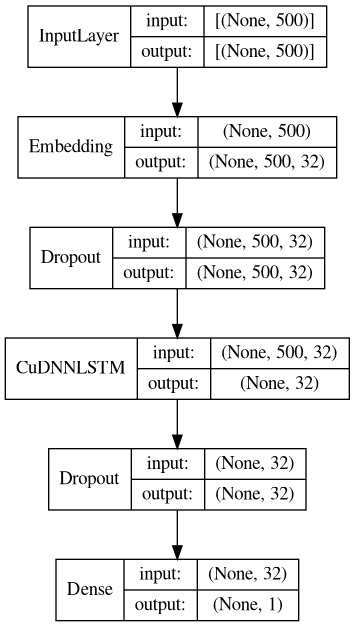

In [14]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Train the LSTM

Use the [fit method](https://keras.io/api/models/model_training_apis/#fit-method) to Train the LSTM.

In [16]:
# Train the LSTM for 3 epochs by feeding in the training data and set validation split as 0.2 and return the logs 
# and save it as history.
# Use 256 as batch size.
### START CODE HERE ###
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=3,
                   batch_size=256)
### END CODE HERE ###

Epoch 1/3


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential_2/cu_dnnlstm_1/CudnnRNNV2}} with these attrs: [dropout=0, seed=0, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU]
Registered kernels:
  <no registered kernels>

	 [[sequential_2/cu_dnnlstm_1/CudnnRNNV2]] [Op:__inference_train_function_3336]

## Evaluate model with test data and view results


In [ ]:
from sklearn.metrics import classification_report
# Use predict_classes from the Sequential API to get prediction classes for test data and create a classification report.
### START CODE HERE ###
predicted_classes = None
print(classification_report(None))
### END CODE HERE ###

## Create an Area under the ROC Curve Plot

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 

Further Reading: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Use predict to make predictions on the test set and return it as y_pred.
# Then use sklearn's roc_curve API to calculate the false positive and true positive rate and return the threshold.
# Finally, use the false positive and true positive rate to calculate the Area Under the Curve using the auc API.
### START CODE HERE ###
y_pred = None
fpr, tpr, thresholds = None
roc_auc = None
### END CODE HERE ###

def plot_roc_curve(fpr,tpr, roc_auc): 
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right") 
    plt.show()    
  
plot_roc_curve (fpr,tpr, roc_auc)

## Run your own text against the trained model

This is a fun way to test out the limits of the trained model. To avoid getting errors - type in lower case only and do not use punctuation! 

You'll see the raw prediction from the model - basically a value between 0 and 1.



In [ ]:
# Write your own review for example:
# review = "this was a terrible film with too much sex and violence i walked out halfway through"
review = None

# Encode review (replace word with integers)
review_encoded = [word_index[word] for word in review.split(" ")]

# Ensure review_encoded is 500 words long by padding it using pad_sequences
### START CODE HERE ###
review_padded = None
### END CODE HERE ###

# Run your review_padded against the trained model
### START CODE HERE ###
raw_prediction = model.predict(array([None][0]))[0][0]
### END CODE HERE ###
prediction = int(round(raw_prediction))


# Test the model and print the result
print("Review: " + review)
print("Raw Prediction: " + str(raw_prediction))
print("Predicted Class: " + class_names[prediction])